# Paper description 

In this notebook I will be replicating the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

paper principle: It's main goal to to apply the technique of attention described in [Attention Is All You Need](https://arxiv.org/abs/1706.03762) to images. It does this by spliting an image into a 16x16 grid, flattening each patch and feeding it into an ordinary transform architecture.

# Imports and data pre-processing

Challenges: Class names are in a different language

In [2]:
try:
    import einops
except:
    print(f"einops not installed as required, installing...")
    !pip3 install einops
    import einops
    
try:
    import torchinfo
except:
    print(f"torchinfo not installed as required, installing...")
    !pip3 install torchinfo
    import torchinfo

einops not installed as required, installing...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from einops import rearrange, reduce, repeat

import requests
import zipfile
from pathlib import Path
import os

import random
from PIL import Image

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

In [4]:
print(f'torch version: {torch.__version__}')

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch version: 1.13.0+cpu
using device: cpu


In [5]:
# Setup path to data folder
data_path = Path("/kaggle/input/animals10/raw-img/")

for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 10 directories and 0 images in '/kaggle/input/animals10/raw-img'.
There are 0 directories and 2623 images in '/kaggle/input/animals10/raw-img/cavallo'.
There are 0 directories and 1820 images in '/kaggle/input/animals10/raw-img/pecora'.
There are 0 directories and 1446 images in '/kaggle/input/animals10/raw-img/elefante'.
There are 0 directories and 1668 images in '/kaggle/input/animals10/raw-img/gatto'.
There are 0 directories and 1862 images in '/kaggle/input/animals10/raw-img/scoiattolo'.
There are 0 directories and 3098 images in '/kaggle/input/animals10/raw-img/gallina'.
There are 0 directories and 4821 images in '/kaggle/input/animals10/raw-img/ragno'.
There are 0 directories and 1866 images in '/kaggle/input/animals10/raw-img/mucca'.
There are 0 directories and 4863 images in '/kaggle/input/animals10/raw-img/cane'.
There are 0 directories and 2112 images in '/kaggle/input/animals10/raw-img/farfalla'.


Random image path: /kaggle/input/animals10/raw-img/ragno/e83cb0062ff5073ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb3b9_640.jpg | class: ragno | dims: 422x640 


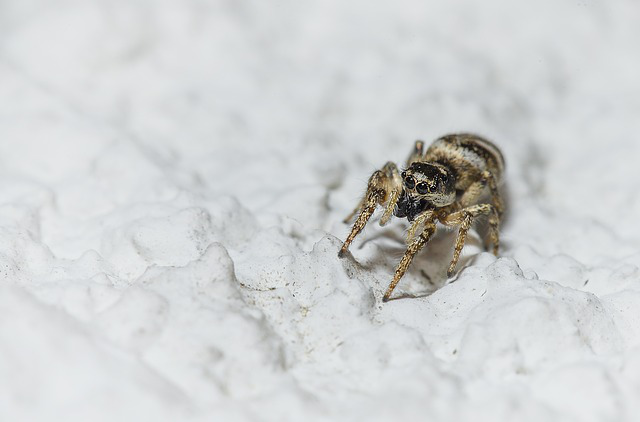

In [6]:
random.seed(42) 
image_path_list = list(data_path.glob("*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path} | class: {image_class} | dims: {img.height}x{img.width} ")
img

In [7]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor() #also converts pixel values from 0-255 to 0.0-1.0 
])

# Use ImageFolder to create dataset(s)
data_path = Path("/kaggle/input/animals10/raw-img")
full_data = datasets.ImageFolder(root=data_path, # target folder of images
                                  transform=data_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

print(f"Train data:\n{full_data}\n")

class_names = full_data.classes
class_to_idx = full_data.class_to_idx

translate_dict = {"cane": "dog",
                  "cavallo": "horse",
                  "elefante": "elephant",
                  "farfalla": "butterfly",
                  "gallina": "chicken",
                  "gatto": "cat",
                  "mucca": "cow",
                  "pecora": "sheep",
                  "ragno" : "spider",
                  "scoiattolo": "squirrel"}
print(translate_dict)

Train data:
Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/input/animals10/raw-img
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

{'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'ragno': 'spider', 'scoiattolo': 'squirrel'}


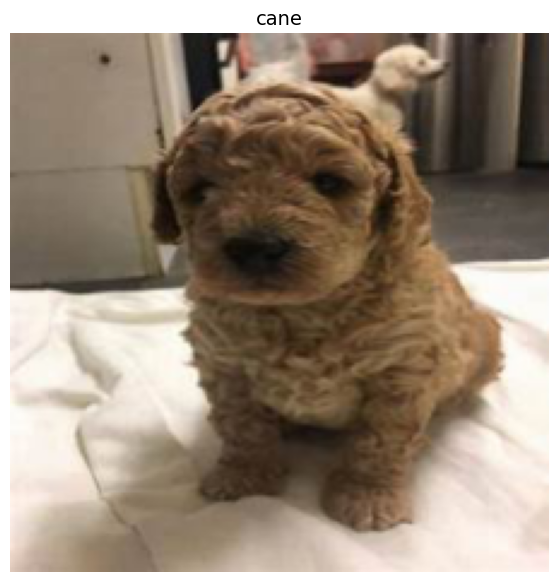

In [8]:
#displaying image after transforms
img, label = full_data[27][0], full_data[27][1]
img = rearrange(img, 'c h w -> h w c')
# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img)
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## Hyperparameters

In [68]:
TEST_SIZE = 0.2
BATCH_SIZE = 10
SEED = 3

In [69]:
# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(full_data)),
    full_data.targets,
    stratify=full_data.targets,
    test_size=TEST_SIZE,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(full_data, train_indices)
test_split = Subset(full_data, test_indices)

# create batches
train_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_split, batch_size=BATCH_SIZE)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

Length of train_dataloader: 2095 batches of size 10
Length of test_dataloader: 524 batches of size 10
torch.Size([10, 3, 224, 224]) torch.Size([10])
torch.Size([10, 3, 224, 224]) torch.Size([10])


## Display patches

Number of patches per row: 16        
Number of patches per column: 16        
Total patches: 256        
Patch size: 14 pixels x 14 pixels


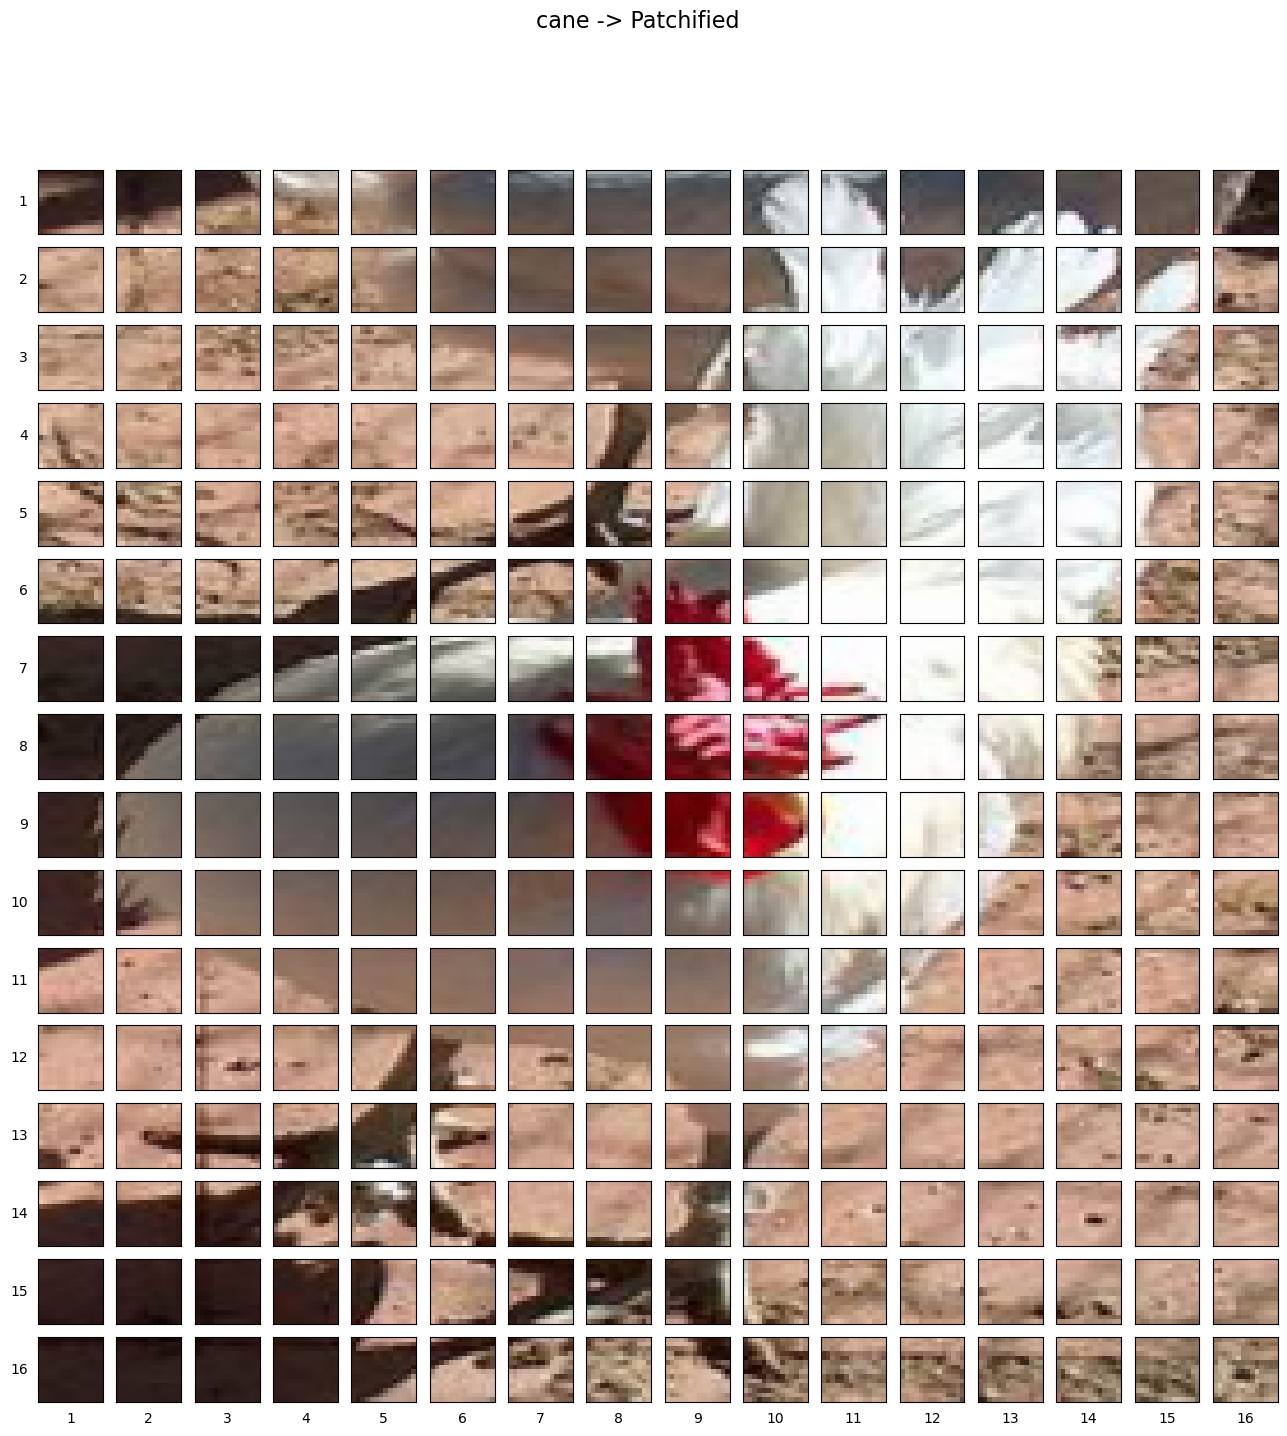

In [11]:
# # Display patches

# image_permuted = rearrange(train_features_batch[0], 'c h w -> h w c')
# # make sure img_size and patch_size are compatible
# img_size = image_permuted.shape[1]
# num_patches = 16
# patch_size = 14
# assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
# print(f"Number of patches per row: {num_patches}\
#         \nNumber of patches per column: {num_patches}\
#         \nTotal patches: {num_patches*num_patches}\
#         \nPatch size: {patch_size} pixels x {patch_size} pixels")

# # Create a series of subplots
# fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
#                         ncols=img_size // patch_size, 
#                         figsize=(num_patches, num_patches),
#                         sharex=True,
#                         sharey=True)

# # Loop through height and width of image
# for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
#     for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
#         # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
#         axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
#                                         patch_width:patch_width+patch_size, # iterate through width
#                                         :]) # get all color channels
        
#         # Set up label information, remove the ticks for clarity and set labels to outside
#         axs[i, j].set_ylabel(i+1, 
#                              rotation="horizontal", 
#                              horizontalalignment="right", 
#                              verticalalignment="center") 
#         axs[i, j].set_xlabel(j+1) 
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])
#         axs[i, j].label_outer()

# # Set a super title
# fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
# plt.show()

# Model

## Description and images from paper

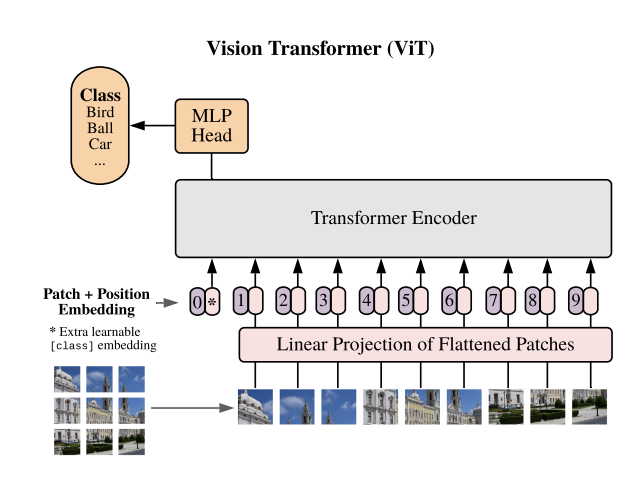

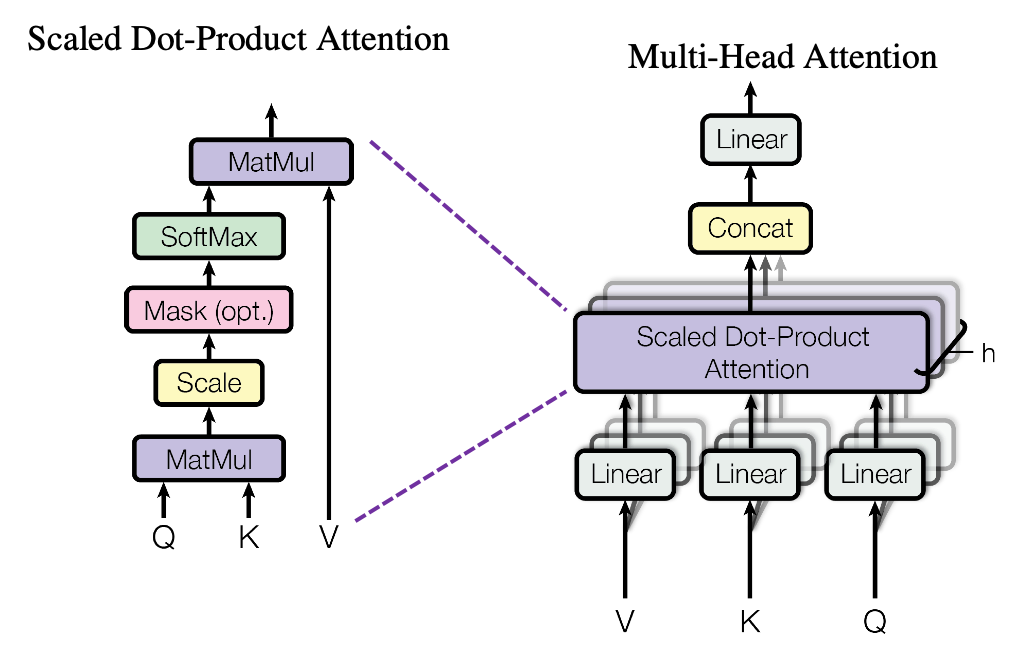

- [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

- [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

The MLP contains two layers with a GELU non-linearity.
$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$


$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$


$$
\begin{aligned}
\operatorname{MultiHead}(Q, K, V) & =\operatorname{Concat}\left(\operatorname{head}_1, \ldots, \operatorname{head}_{\mathrm{h}}\right) W^O \\
\text { where head }_{\mathrm{i}} & =\operatorname{Attention}\left(Q W_i^Q, K W_i^K, V W_i^V\right)
\end{aligned}
$$
Where the projections are parameter matrices $W_i^Q \in \mathbb{R}^{d_{\text {model }} \times d_k}, W_i^K \in \mathbb{R}^{d_{\text {model }} \times d_k}, W_i^V \in \mathbb{R}^{d_{\text {model }} \times d_v}$ and $W^O \in \mathbb{R}^{h d_v \times d_{\text {model }}}$.


## Implementation

In [70]:
x = train_features_batch
x = x.to(device)
x.shape

torch.Size([10, 3, 224, 224])

In [71]:
h = 8 # parallel attention layers/heads
d_k = 64 #queries, keys dimension
d_v = 64 # values 
d_model = 512 
patches = 16 # patches per row/column
assert x.shape[2] % p == 0, "Invalid patch size"

In [78]:
class ViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.D = 64 # constant latent vector size
        self.PATCH_SIZE = 14
        self.BATCH_SIZE = BATCH_SIZE
        
        #Linear projection
        self.proj = torch.nn.Sequential(torch.nn.Linear(in_features=588,
                                                        out_features = self.D))
        
        
        self.learnable = torch.rand(self.D)
        
                                                     
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        #1. Create patches
        x = rearrange(x, 'b c (p1 h) (p2 w) -> b (h w) (c p1 p2)',
                      p1=self.PATCH_SIZE, p2=self.PATCH_SIZE)
        #Vision Transformer (ViT) Paper description:
        # Reshape image X (h w c) into a sequence of 
        # flattened 2d patches X_p(HW/P^2 P^2.C), i,e, size 256x588
        
        #2. Linear projection
        x = self.proj(x)
        
        #3. Add extra learnable [class] embedding
        learnable_formatted = repeat(self.learnable, 'd -> b () d', b = self.BATCH_SIZE)
        x = torch.cat([learnable_formatted, y], dim = 1)
        
        #4. Add positional embeddings
        
        # Find Q, K, V
        # q, kv = 
        
        return x
    
model = ViT().to(device)
y = model(x)
y.shape

torch.Size([10, 257, 64])

In [ ]:
# Layer norm applied before every block, residual connections after every block

In [ ]:
# torch.chunk(y, chunks=3, dim=2)[0].shape